<a href="https://colab.research.google.com/github/AsmaTidafi/Bert-keras-implementation/blob/main/Bert_for_Question_Paragraph_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow
!pip install tokenizers
!pip install transformers

import os
import re
import string
import sklearn
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel
from transformers import BertConfig

## Load the data

In [ ]:
df_train = pd.read_csv('train.tsv', delimiter='\t', names=['index', 'question', 'sentence', 'label'])
df_train.set_index('index', inplace=True)

df_test = pd.read_csv('dev.tsv', delimiter='\t', names=['index', 'question', 'sentence', 'label'])
df_test.set_index('index', inplace=True)

In [ ]:
df_train = df_train.drop([df_train.index[0]])
df_test = df_test.drop([df_test.index[0]])

In [ ]:
df_test = df_test[df_test.label.str.contains('entailment')]
df_train = df_train[df_train.label.str.contains('entailment')]

In [ ]:
possible_labels = df_train.label.unique()

In [ ]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [ ]:
label_dict

In [ ]:
df_train['label'] = df_train.label.replace(label_dict)
df_test['label'] = df_test.label.replace(label_dict)

In [ ]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df_train, test_size=0.2, random_state=0)
df_train = pd.DataFrame(train)
df_val = pd.DataFrame(val)

In [ ]:
len(df_train)

In [ ]:
len(df_val)

## Set up tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

In [ ]:
max_len = 300
class SquadExample:
    def __init__(self, question, context, is_impossible):
        self.question = question
        self.context = context
        self.is_impossible = is_impossible

    def preprocess(self):
        context = self.context
        question = self.question
        is_impossible = self.is_impossible

        # Clean context, answer and question
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())

        # Tokenize context
        tokenized_context = tokenizer.encode(context)

        # Tokenize question
        tokenized_question = tokenizer.encode(question)

        # Create inputs
        input_ids = tokenized_context + tokenized_question[1:]
        token_type_ids = [0] * len(tokenized_context) + [1] * len(tokenized_question[1:])
        attention_mask = [1] * len(input_ids)

        # Pad and create attention masks.
        # Skip if truncation is needed
        padding_length = max_len - len(input_ids)
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:  # skip
            tokenized_context_ = []
            m = len(tokenized_context) + padding_length - 1
            
            i = 0
            for item in tokenized_context:
              if i > m:
                break
              else:
                tokenized_context_.append(item)
                i += 1
            
            input_ids = tokenized_context_ + tokenized_question[1:]
            token_type_ids = [0] * len(tokenized_context_) + [1] * len(tokenized_question[1:])
            attention_mask = [1] * len(input_ids)

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.is_impossible = is_impossible


def create_squad_examples(df):
    squad_examples = []
    for index, row in df.iterrows():
        question = str(row['question'])
        sentence = str(row['sentence'])
        label = row['label']
        squad_eg = SquadExample(question, sentence, label)
        squad_eg.preprocess()
        squad_examples.append(squad_eg)
    return squad_examples


def create_inputs_targets(squad_examples):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "is_impossible": [],
    }
    for item in squad_examples:
        for key in dataset_dict:
            dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    y = [dataset_dict["is_impossible"]]

    return x, y

## Tokenize data

In [ ]:
train_squad_examples = create_squad_examples(df_train)
val_squad_examples = create_squad_examples(df_val)
test_squad_examples = create_squad_examples(df_test)

In [ ]:
x_train, y_train = create_inputs_targets(train_squad_examples)
print(f"{len(train_squad_examples)} training points created.")

x_val, y_val = create_inputs_targets(val_squad_examples)
print(f"{len(val_squad_examples)} val points created.")

x_test, y_test = create_inputs_targets(test_squad_examples)
print(f"{len(test_squad_examples)} test points created.")

## Create model class

In [ ]:
def create_model(dropout_value):
    config = BertConfig(hidden_dropout_prob=dropout_value)
    ## BERT encoder
    encoder = TFBertModel.from_pretrained("bert-base-uncased", config=config)
    
    # QA Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    output = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )[1]
    
    output = layers.Dense(1, use_bias=True)(output)
    output = layers.Activation(keras.activations.sigmoid)(output)


    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=output,
    )

    # creates an optimizer with learning rate schedule
    optimizer = tf.keras.optimizers.Adam(lr=1e-5)
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)
               tf.keras.metrics.TruePositives(),
               tf.keras.metrics.TrueNegatives(),
               tf.keras.metrics.FalsePositives(),
               tf.keras.metrics.FalseNegatives()]
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics)
    
    return model

## Use TPU

In [ ]:
# Create distribution strategy
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.78.66.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.78.66.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## Run training

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Create model
with strategy.scope():
    model = create_model(0.2)

model.summary()

output = model.fit(x_train,
                  y_train,
                  epochs=100,
                  verbose=1,
                  batch_size=128,
                  validation_data=(x_val, y_val),
                  callbacks = callback)

645/645 [==============================] - 277s 429ms/step - loss: 0.4834 - accuracy: 0.8203 - val_loss: 0.4383 - val_accuracy: 0.8699
Epoch 2/100
645/645 [==============================] - 226s 350ms/step - loss: 0.4291 - accuracy: 0.8801 - val_loss: 0.4316 - val_accuracy: 0.8758
Epoch 3/100
645/645 [==============================] - 226s 351ms/step - loss: 0.4072 - accuracy: 0.9034 - val_loss: 0.4285 - val_accuracy: 0.8808
Epoch 4/100
645/645 [==============================] - 227s 352ms/step - loss: 0.3933 - accuracy: 0.9180 - val_loss: 0.4259 - val_accuracy: 0.8836
Epoch 5/100
645/645 [==============================] - 227s 353ms/step - loss: 0.3844 - accuracy: 0.9274 - val_loss: 0.4250 - val_accuracy: 0.8847
Epoch 6/100
645/645 [==============================] - 227s 352ms/step - loss: 0.3782 - accuracy: 0.9337 - val_loss: 0.4250 - val_accuracy: 0.8854
Epoch 7/100
645/645 [==============================] - 228s 353ms/step - loss: 0.3733 - accuracy: 0.9391 - val_loss: 0.4232 - val_

## Plot graphics

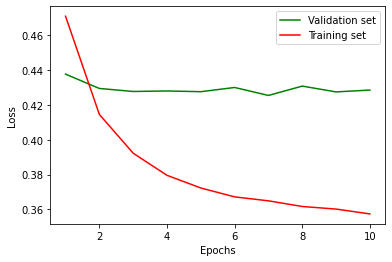

In [ ]:
plot([x for x in range(1,len(output.history['val_loss'])+1)], [x for x in output.history['val_loss']], label="Validation set", color="g")
plot([x for x in range(1,len(output.history['val_loss'])+1)], [x for x in output.history['loss']], label="Training set", color="r")
ylabel('Loss')
xlabel('Epochs')
legend(loc='best')
show()

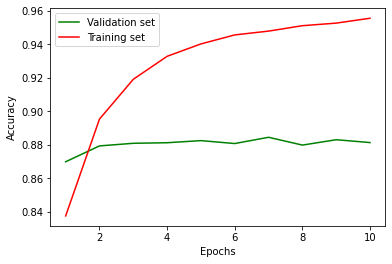

In [ ]:
plot([x for x in range(1,len(output.history['val_loss'])+1)], [x for x in output.history['val_accuracy']], label="Validation set", color="g")
plot([x for x in range(1,len(output.history['val_loss'])+1)], [x for x in output.history['accuracy']], label="Training set", color="r")
ylabel('Accuracy')
xlabel('Epochs')
legend(loc='best')
show()

In [ ]:
## Save the model
model.save_weights('/content/drive/My Drive/Model.h5')

## Test the model

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
y = []
for i in y_pred:
  if i < 0.5:
    y.append(0)
  else:
    y.append(1)

In [ ]:
sklearn.metrics.accuracy_score(y_test[0], y)

0.9046714774022028